In [1]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle

from src.models.vision import get_encoder

/data/scratch/ankile/miniconda3/envs/rlgpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def print_stats(data):
    print(f"min: {np.min(data)}, max: {np.max(data)}, mean: {np.mean(data)}, std: {np.std(data)}")


def make_hist(data, title=""):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(title)

    ax1.hist(data, bins=100)
    ax1.set_title("Linear scale")

    ax2.hist(data, bins=100, log=True)
    ax2.set_title("Log scale")

## Investigate VIP

In [2]:
vip = zarr.open("/data/scratch/ankile/furniture-data/data/processed/sim/feature/vip/one_leg/data.zarr")["observations"][
    10_000:, 14:
]

In [3]:
vip.shape

(265395, 2048)

In [4]:
vip_flat = vip.reshape(-1)

In [30]:
## Get the min and max for each feature and save for later
feature1 = vip[:, :1024]
feature2 = vip[:, 1024:]

stats = {
    "feature1": {
        "min": np.min(feature1, axis=0),
        "max": np.max(feature1, axis=0),
    },
    "feature2": {
        "min": np.min(feature2, axis=0),
        "max": np.max(feature2, axis=0),
    },
}

with open("/data/scratch/ankile/furniture-diffusion/src/data/vip_stats.pkl", "wb") as f:
    pickle.dump(stats, f)

min: -29.05980110168457, max: 39.561981201171875, mean: 0.0171197559684515, std: 1.5909842252731323


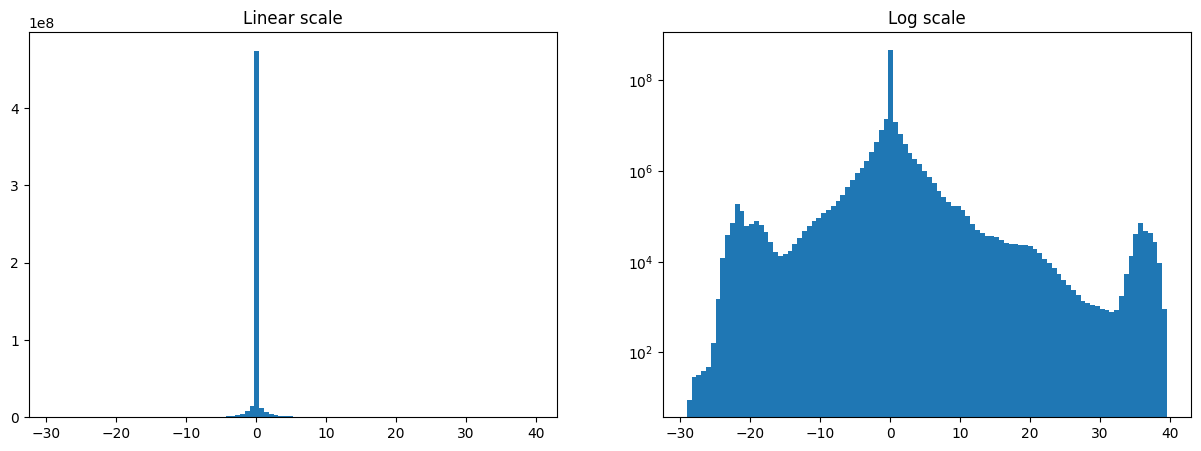

In [7]:
print_stats(vip_flat)
make_hist(vip_flat)

Text(0.5, 1.0, 'Max per feature')

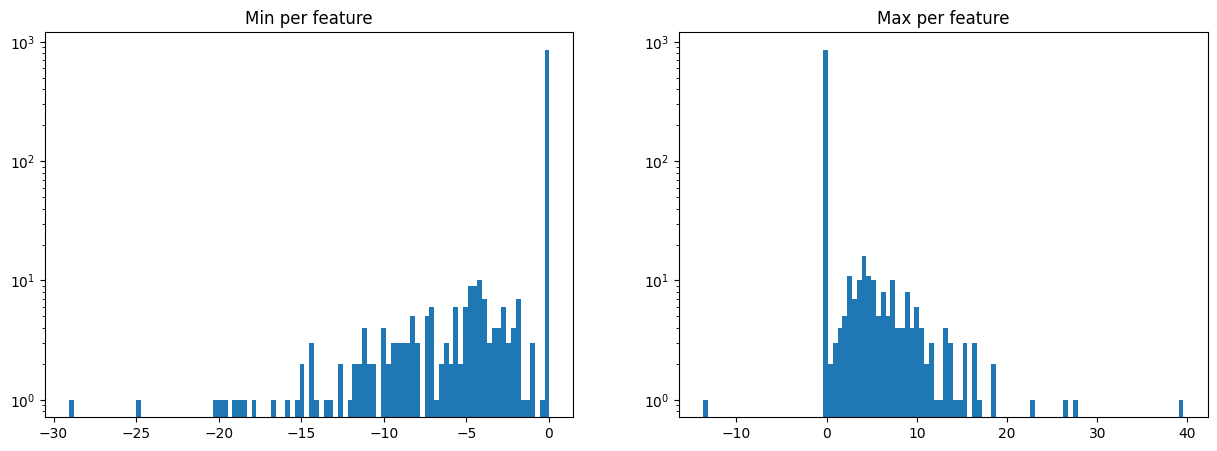

In [11]:
# Find min and max for each feature and plot the distribution
feature1 = vip[:, :1024]
feature2 = vip[:, 1024:]

feature = np.concatenate([feature1, feature2], axis=0)

min_per_dim = np.min(feature, axis=0)
max_per_dim = np.max(feature, axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.hist(min_per_dim, bins=100, log=True)
ax1.set_title("Min per feature")

ax2.hist(max_per_dim, bins=100, log=True)
ax2.set_title("Max per feature")

## Investigate R3M

### R3M 50

In [13]:
r3m50 = zarr.open("/data/scratch/ankile/furniture-data/data/processed/sim/feature/r3m_50/one_leg/low/data.zarr")[
    "observations"
][:10_000, 14:]

r3m50_flat = r3m50.reshape(-1)
r3m50.shape

(10000, 4096)

min: 0.0, max: 6.069972991943359, mean: 0.02553071826696396, std: 0.15891559422016144


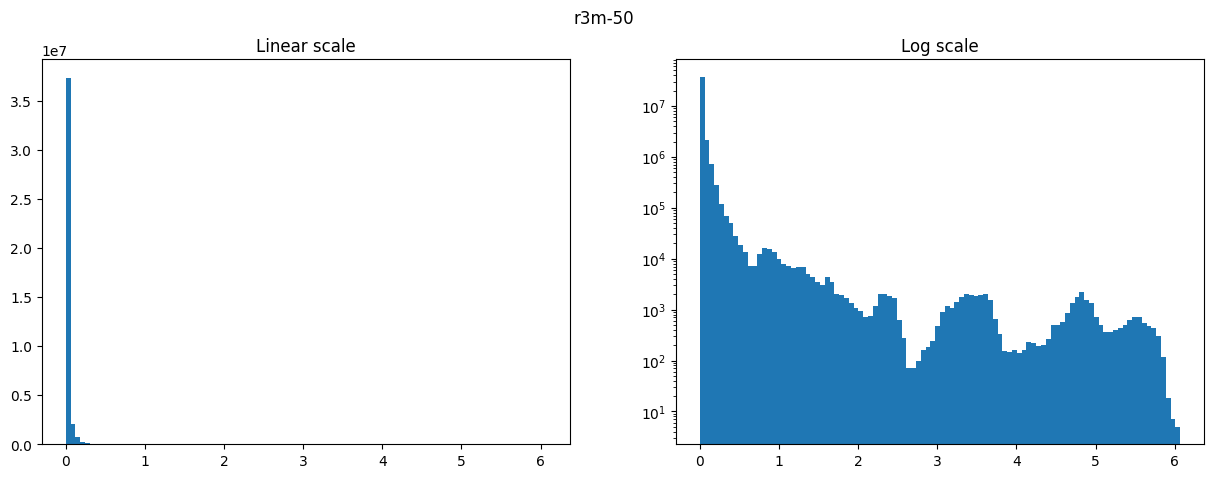

In [14]:
print_stats(r3m50_flat)
make_hist(r3m50_flat, "r3m-50")

### R3M 18

In [10]:
r3m18 = zarr.open("/data/scratch/ankile/furniture-data/data/processed/sim/feature/r3m_18/one_leg/low/data.zarr")[
    "observations"
][:10_000, 14:]

In [11]:
r3m18_flat = r3m18.reshape(-1)
r3m18.shape

(10000, 1024)

min: 0.0, max: 3.8334157466888428, mean: 0.07139602303504944, std: 0.24831198155879974


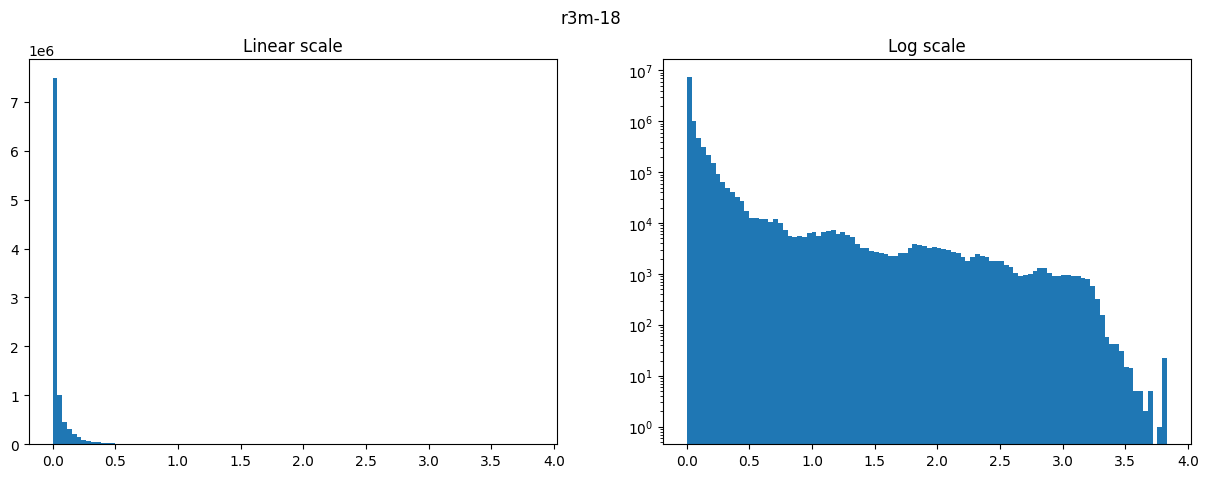

In [12]:
print_stats(r3m18_flat)
make_hist(r3m18_flat, "r3m-18")

In [11]:
enc = get_encoder("r3m_34", device="cuda:1").model
norm = enc.normlayer

enc = enc.convnet

enc

/data/scratch/ankile/miniconda3/envs/rlgpu/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/data/scratch/ankile/miniconda3/envs/rlgpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/scratch/ankile/miniconda3/envs/rlgpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
# Create 10_000 images randomly between [0, 255]
r3m18 = np.concatenate(
    [
        enc(norm(torch.randint(0, 255, (1_000, 3, 224, 224), dtype=torch.uint8, device="cuda:1") / 255.0))
        .detach()
        .cpu()
        .numpy()
        for _ in range(10)
    ]
)

r3m18_flat = r3m18.reshape(-1)
r3m18.shape

(10000, 512)

min: 0.0, max: 4.026891708374023, mean: 0.0708630159497261, std: 0.2742857336997986


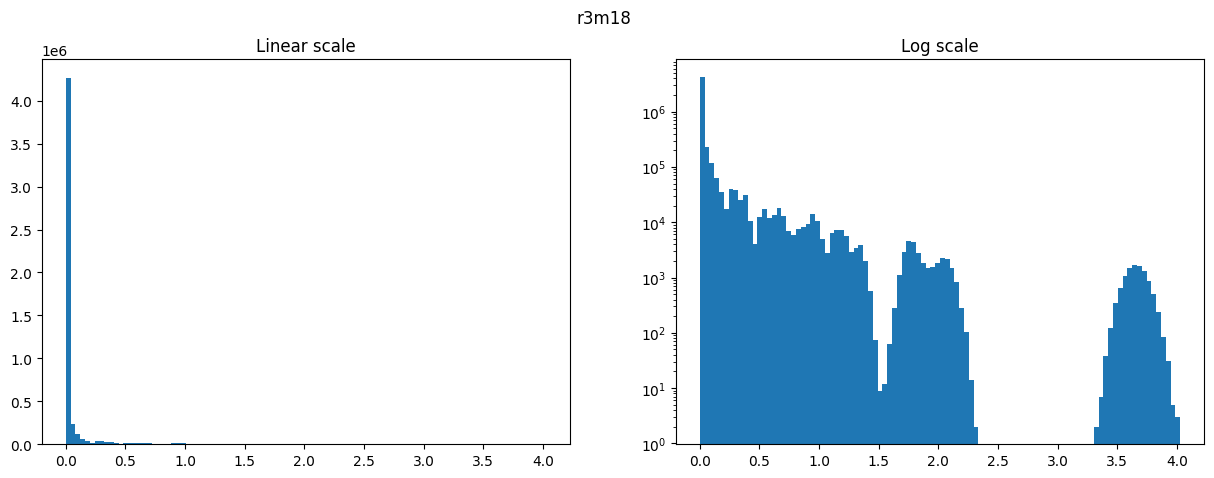

In [13]:
print_stats(r3m18_flat)
make_hist(r3m18_flat, title="r3m18")

## Investigate DINO

### Small

In [3]:
dino_small = zarr.open("/data/scratch/ankile/furniture-data/data/processed/sim/feature/dinov2-small/one_leg/data.zarr")[
    "observations"
][:1_000, 14:]

In [4]:
dino_small.shape

(1000, 768)

min: -9.816547393798828, max: 9.743276596069336, mean: -0.004983902599563609, std: 1.661579145850393


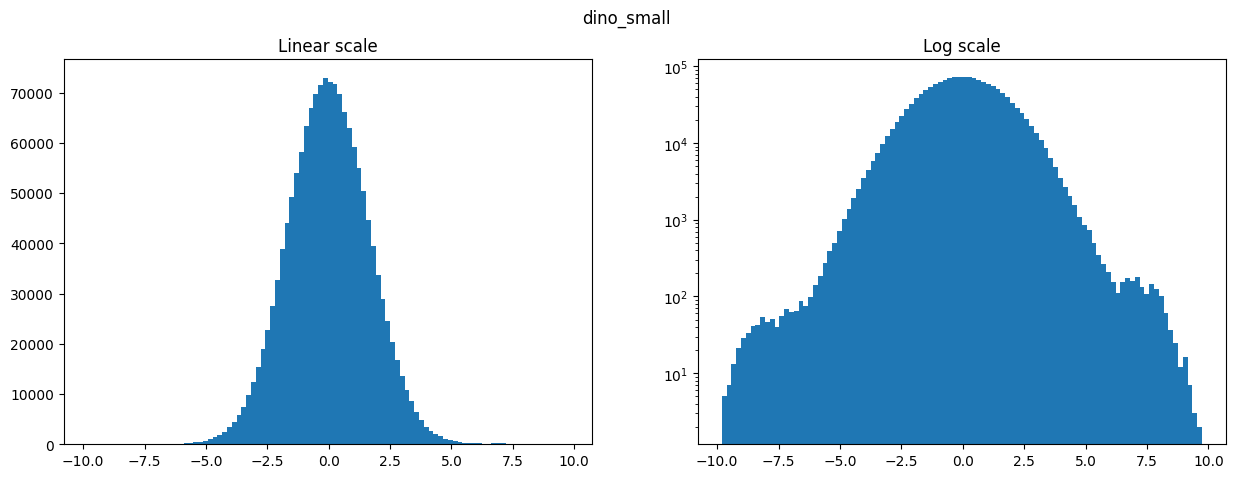

In [19]:
print_stats(dino_small.reshape(-1))
make_hist(dino_small.reshape(-1), title="dino_small")

### Base

In [8]:
dino_base = zarr.open("/data/scratch/ankile/furniture-data/data/processed/sim/feature/dinov2-base/one_leg/data.zarr")[
    "observations"
][:1_000, 14:]

In [9]:
dino_base.shape

(1000, 1536)

min: -9.816547393798828, max: 9.743276596069336, mean: -0.004983902599563609, std: 1.661579145850393


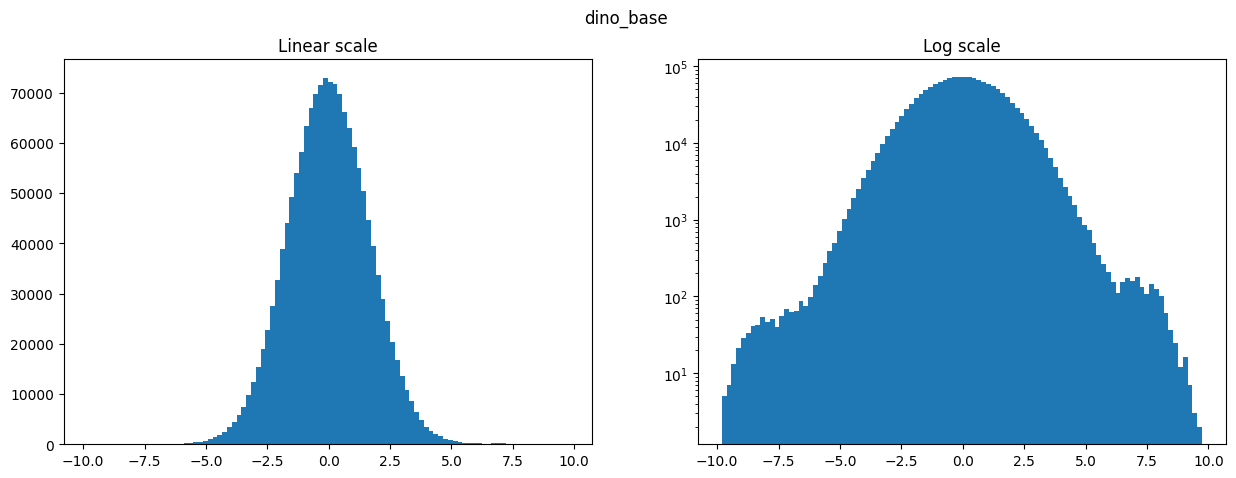

In [20]:
print_stats(dino_base.reshape(-1))
make_hist(dino_base.reshape(-1), title="dino_base")

### Large

In [12]:
dino_large = zarr.open("/data/scratch/ankile/furniture-data/data/processed/sim/feature/dinov2-large/one_leg/data.zarr")[
    "observations"
][:1_000, 14:]

In [13]:
dino_large.shape

(1000, 2048)

min: -7.866496562957764, max: 7.395058631896973, mean: 0.0075769298619132695, std: 1.4145341163643903


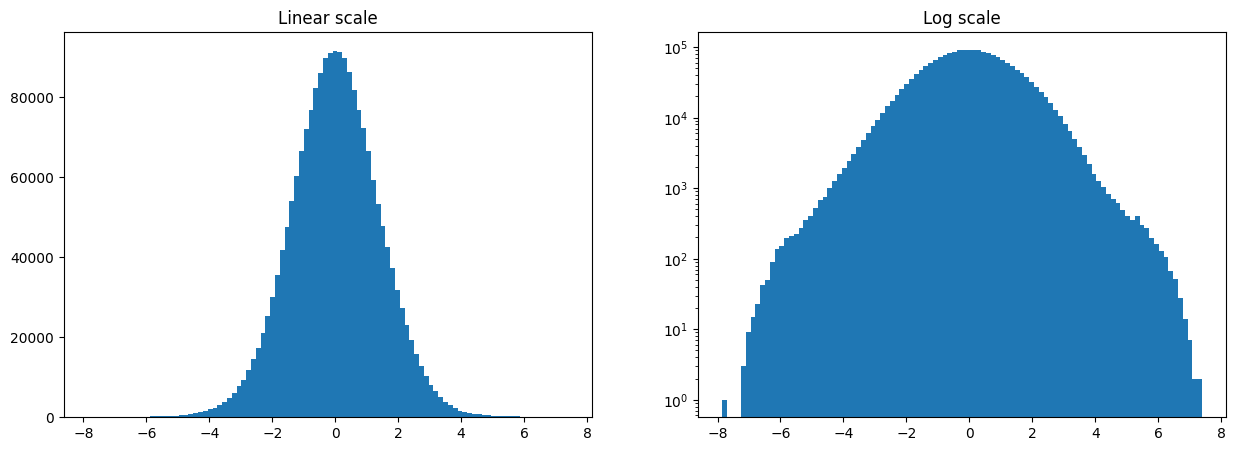

In [14]:
print_stats(dino_large.reshape(-1))
make_hist(dino_large.reshape(-1), title="dino_large")

## VIP separated

In [4]:
vips = zarr.open("/data/scratch/ankile/furniture-data/data/processed/sim/feature_separate/vip/one_leg/data.zarr")

In [5]:
vips["episode_ends"][-1]

248151

In [6]:
for key, value in vips.items():
    print(key, len(value))

action 248151
episode_ends 490
feature1 248151
feature2 248151
furniture 490
rewards 248151
robot_state 248151
skills 248151


TypeError: len() of unsized object